In [1]:
%tensorflow_version 2.9.2
import tensorflow as tf
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.12.0'

# Dataset Statistics

Dataset Downloading

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
!pip install httplib2==0.15.0
!pip install google-api-python-client==1.7.11

#%cd /content/drive/My Drive/hu_joint_nlu_multiturn/M2M
%cd /content/drive/My Drive/tri-model/M2M

Mounted at /content/drive/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: httplib2
    Found existing installation: httplib2 0.21.0
    Uninstalling httplib2-0.21.0:
      Successfully uninstalled httplib2-0.21.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for google-api-python-client: filename=google_api_python_client-1.7.11-py3-none-any.whl size=56528 sha256=7395f4fe2edd04a63d57c7bf0eea3bdaa8219a8f89cbcec6270d84ae3ee1dfe4
  Stored in directory: /root/.cache/pip/wheels/1b/77/9d/4196a0a387e67794aeb74cae03c16228f23942199af842f3b2
Successfully built google-api-python-client
  Attempting uninstall: uritemplate
    Found existing installation: uritemplate 4.1.1
    Uninstalling uritemplate-4.1.1:
      Successfully uninstalled uritemplate-4.1.1
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.84.0
    Uninstalling google-api-python-client-2.84.0:
      Successfully uninstalled google-api-python-client-2.84.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of th

/content/drive/My Drive/tri-model/M2M


In [3]:

import glob
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
#from keras_preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences

files = glob.glob('data/sim-*/train.json')

print(__name__)
print(files)

train_data = []

if __name__ == '__main__':
  for fn in files:
    with open(fn, 'rb') as f:
        train_data.append(pd.read_json(fn))

train_data = pd.concat(train_data,ignore_index=True)

files = glob.glob('data/sim-*/dev.json')
dev_data = []

if __name__ == '__main__':
  for fn in files:
    with open(fn, 'rb') as f:
        dev_data.append(pd.read_json(fn))

dev_data = pd.concat(dev_data,ignore_index=True)

files = glob.glob('data/sim-*/test.json')
test_data = []

if __name__ == '__main__':
  for fn in files:
    with open(fn, 'rb') as f:
        test_data.append(pd.read_json(fn))

test_data = pd.concat(test_data,ignore_index=True)

__main__
['data/sim-R/train.json', 'data/sim-M/train.json']


An example of dialogue flows

In [4]:
train_data['turns'][45]

[{'dialogue_state': [{'slot': 'date', 'value': 'next monday'},
   {'slot': 'num_people', 'value': '2'}],
  'user_acts': [{'type': 'GREETING'}],
  'user_intents': ['RESERVE_RESTAURANT'],
  'user_utterance': {'slots': [{'exclusive_end': 15,
     'slot': 'date',
     'start': 13},
    {'exclusive_end': 17, 'slot': 'num_people', 'start': 16}],
   'text': "hi , i ' d like to make a reservation at a restaurant next monday for 2 people .",
   'tokens': ['hi',
    ',',
    'i',
    "'",
    'd',
    'like',
    'to',
    'make',
    'a',
    'reservation',
    'at',
    'a',
    'restaurant',
    'next',
    'monday',
    'for',
    '2',
    'people',
    '.']}},
 {'dialogue_state': [{'slot': 'date', 'value': 'next monday'},
   {'slot': 'num_people', 'value': '2'},
   {'slot': 'restaurant_name', 'value': 'sumiko'},
   {'slot': 'time', 'value': 'dontcare'}],
  'system_acts': [{'slot': 'restaurant_name', 'type': 'REQUEST'},
   {'slot': 'time', 'type': 'REQUEST'}],
  'system_utterance': {'slots':

In [5]:
dialogue_id = 281
print('The domain of the following dialogue is',
      [y['user_intents'] for y in train_data.iloc[dialogue_id]['turns'] if 'user_intents' in y][0][0], '\n\n')

for utterance in train_data['turns'][dialogue_id]:
  if 'system_utterance' in utterance:
    print(utterance['system_utterance']['text'])
    print(utterance['system_acts'])
  print(utterance['user_utterance']['text'])
  print('(Acts:', utterance['user_acts'][0]['type']+': ', end='')
  print(utterance['dialogue_state'], end='')
  print(')\n')


The domain of the following dialogue is RESERVE_RESTAURANT 


hi . can you reserve a table at a restaurant for me .
(Acts: GREETING: [])

sure . on what date and at which restaurant ?
[{'slot': 'date', 'type': 'REQUEST'}, {'slot': 'restaurant_name', 'type': 'REQUEST'}]
i want a table at sumiko for tonight
(Acts: INFORM: [{'slot': 'date', 'value': 'tonight'}, {'slot': 'restaurant_name', 'value': 'sumiko'}])

how many people do you need a table for ?
[{'slot': 'time', 'type': 'REQUEST'}, {'slot': 'num_people', 'type': 'REQUEST'}]
3 people at 8 pm
(Acts: INFORM: [{'slot': 'num_people', 'value': '3'}, {'slot': 'date', 'value': 'tonight'}, {'slot': 'restaurant_name', 'value': 'sumiko'}, {'slot': 'time', 'value': '8 pm'}])

8 pm is not available . how about 5 pm , 7.15 pm or 7.30 pm ?
[{'slot': 'time', 'type': 'NEGATE', 'value': '8 pm'}, {'slot': 'time', 'type': 'SELECT', 'value': '5 pm'}, {'slot': 'time', 'type': 'SELECT', 'value': '7.15 pm'}, {'slot': 'time', 'type': 'SELECT', 'value': '7.

In [6]:
def get_slot_intent_domain(dataset):
  tokens = []
  domains = []
  slots = []
  slot_values = []
  turns = []
  intents = []
  dataset_seq = []
  dataset_slot = []
  dataset_intent = []
  dataset_domain = []
  slot_loc = []
  max_turn_len = 0

  for i in range(len(dataset)):
    tokens += [y['user_utterance']['tokens'] for y in dataset.iloc[i]['turns'] if 'user_utterance' in y] + \
    [y['system_utterance']['tokens'] for y in dataset.iloc[i]['turns'] if 'system_utterance' in y]
    turns.append(len([y for y in dataset.iloc[i]['turns'] if 'user_utterance' in y]) +
                len([y for y in dataset.iloc[i]['turns'] if 'system_utterance' in y]))
    max_turn_len = max([len(y['user_utterance']['tokens']) for y in dataset.iloc[i]['turns'] if 'user_utterance' in y]
                      +[len(y['system_utterance']['tokens']) for y in dataset.iloc[i]['turns'] if 'system_utterance' in y] \
                      + [max_turn_len])
    slots.append([[x['slot'] for x in y['dialogue_state']] for y in dataset.iloc[i]['turns']])
    slot_values.append([[x['value'] for x in y['dialogue_state']] for y in dataset.iloc[i]['turns']])
    domains += [y['user_intents'] for y in dataset.iloc[i]['turns'] if 'user_intents' in y]
    intents.append(list(set([y['user_acts'][0]['type'] for y in dataset.iloc[i]['turns'] if len(y['user_acts']) > 0])))

    for utterance in dataset['turns'][i]:
      if 'system_utterance' in utterance:
        dataset_seq.append(utterance['system_utterance']['tokens'])
        slot_loc.append(utterance['system_utterance']['slots'])
        slot_value = []
        for dic in utterance['system_acts']:
          if 'value' in dic:
            slot_value.append({dic['slot']:dic['value']})
          else:
            slot_value.append({})
        dataset_intent.append(utterance['system_acts'][0]['type'])
        dataset_slot.append(slot_value)
        dataset_domain.append(domains[-1])
      if len(utterance['user_acts']):
        dataset_seq.append(utterance['user_utterance']['tokens'])
        dataset_intent.append(utterance['user_acts'][0]['type'])
        dataset_slot.append(utterance['dialogue_state'])
        dataset_domain.append(domains[-1])
        slot_loc.append(utterance['user_utterance']['slots'])

  domains = [x.split('_')[1] for xs in domains for x in xs]
  tokens = [x for xs in tokens for x in xs]
  dataset_domain = [x.split('_')[1] for xs in dataset_domain for x in xs]
  intents = [x for xs in intents for x in xs]
  slots = [x for xs in slots for x in xs]
  unique_slots = sorted(list(set([x for xs in slots for x in xs])))
  average_turns = sum(turns) /len(dataset)
  average_tokens = len(tokens) / sum(turns)

  dataset_token_slot = []
  for seq, slots in zip(dataset_seq, slot_loc):
    dataset_token_slot.append(['O']*len(seq))
    for slot_dic in slots:
      if slot_dic != {}:
          start_loc = slot_dic['start']
          end_loc = slot_dic['exclusive_end']
          this_slot = slot_dic['slot']
          dataset_token_slot[-1][start_loc] = 'B-' + this_slot
          dataset_token_slot[-1][start_loc+1:end_loc] = ['I-' + this_slot]*(end_loc - start_loc - 1)

  return (tokens, sum(turns), domains, max_turn_len, dataset_seq, dataset_slot, dataset_intent, dataset_domain, unique_slots, average_turns, average_tokens, dataset_token_slot)

In [7]:
train_info = get_slot_intent_domain(train_data)
dev_info = get_slot_intent_domain(dev_data)
test_info = get_slot_intent_domain(test_data)

(train_tokens, train_num_turns, train_domains, train_max_turn_len, train_seq, train_slot, train_intent, train_domain, \
 train_unique_slots, train_average_turns, train_average_tokens, train_token_slot) = train_info
(test_tokens, test_num_turns, test_domains, test_max_turn_len, test_seq, test_slot, test_intent, test_domain, \
 test_unique_slots, test_average_turns, test_average_tokens, test_token_slot) = test_info
(dev_tokens, dev_num_turns, dev_domains, dev_max_turn_len, dev_seq, dev_slot, dev_intent, dev_domain, \
 dev_unique_slots, dev_average_turns, dev_average_tokens, dev_token_slot) = dev_info

seqs = train_seq + test_seq + dev_seq
tokens = train_tokens + test_tokens + dev_tokens
num_turns = train_num_turns + test_num_turns + dev_num_turns
token_slot = train_token_slot + test_token_slot + dev_token_slot
domains = train_domain + test_domain + dev_domain
intents = train_intent + test_intent + dev_intent
token_slot = train_token_slot + test_token_slot + dev_token_slot
unique_slots = sorted(list(set(train_unique_slots + test_unique_slots + dev_unique_slots)))
average_turns = train_average_turns + test_average_turns + dev_average_turns
average_tokens = train_average_tokens + test_average_tokens + dev_average_tokens
slot_value = [x for xs in train_slot + test_slot + dev_slot for x in xs]

In [8]:
slot_value_pair = {}
for each_slot_value in slot_value:
  if 'slot' in each_slot_value:
    if each_slot_value['slot'] in slot_value_pair:
      slot_value_pair[each_slot_value['slot']].append(each_slot_value['value'])
    else:
      slot_value_pair[each_slot_value['slot']] = [each_slot_value['value']]
for key in slot_value_pair:
  slot_value_pair[key] = list(set(slot_value_pair[key]))

In [9]:
slot_value_pair

{'num_people': ['4', '6', '5', '3', '2'],
 'restaurant_name': ['ephesus',
  'sushi boat',
  'il fornaio',
  'boats',
  '.ink',
  'high rooftop lounge',
  'amarin',
  'acorn',
  'oren',
  'amber',
  'sumiko',
  'sweet greens',
  'deep blue',
  'los altos grill',
  'the view',
  'amber india',
  'angel',
  'cetrella',
  'the hudson room',
  'sakoon',
  'oren hummus',
  'cheese cake factory',
  'the nest',
  'pepper',
  'the ivy',
  'pompei',
  'evvia',
  'cascal'],
 'date': ['tomorrow',
  'saturday',
  'today',
  'sunday',
  'tonight',
  'tuesday',
  'friday',
  'next monday',
  'wednesday'],
 'time': ['7.30 pm',
  '7.15 pm',
  '6.30 pm',
  '5.30 pm',
  'dontcare',
  '7 pm',
  '8.30 pm',
  '8:00 pm',
  '10:00 pm',
  '4:00 pm',
  '1 pm',
  '12 pm',
  '6 pm',
  '2 pm',
  '5 pm',
  '6:00 pm',
  '8 pm',
  '6.15 pm'],
 'location': ['madison',
  'kirkland',
  'redmond',
  'orlando',
  'morristown',
  'middletown',
  'mountain view',
  'los altos',
  'yorktown heights'],
 'meal': ['lunch', 'bre

Dataset Statistics

In [10]:
unique_intents = sorted(list(set(intents)))
unique_domains = sorted(list(set(domains)))
unique_slots = sorted(list(set(unique_slots)))

print('Domains are', ', '.join(unique_domains))
print('Slots are', ', '.join(unique_slots))
print('Intents are', ', '.join(unique_intents), '\n')

print('Number of dialogues:', len(train_data))
print('Numer of turns:', num_turns)
print('Numer of tokens:', len(tokens))
print('Average turns per dialogue:', round(average_turns,2))
print('Average tokens per utterance:', round(average_tokens,2))
print('Number of slots:', len(unique_slots))  # Distinct slots
print('Number of intents:', len(unique_intents))
print('Number of domains:', len(unique_domains))

Domains are MOVIE, RESTAURANT
Slots are category, date, location, meal, movie, num_people, num_tickets, price_range, rating, restaurant_name, theatre_name, time
Intents are AFFIRM, CANT_UNDERSTAND, CONFIRM, GOOD_BYE, GREETING, INFORM, NEGATE, NOTIFY_FAILURE, NOTIFY_SUCCESS, OFFER, OTHER, REQUEST, REQUEST_ALTS, SELECT, THANK_YOU 

Number of dialogues: 1500
Numer of turns: 27120
Numer of tokens: 224677
Average turns per dialogue: 26.13
Average tokens per utterance: 24.9
Number of slots: 12
Number of intents: 15
Number of domains: 2


## Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# colors = sns.color_palette('pastel')
# slots_ratio = [[x for xs in token_slot for x in xs].count('B-'+slot)+[x for xs in token_slot for x in xs].count('I-'+slot) for slot in unique_slots]
# plt.figure(figsize=(15, 15), tight_layout=True)
# plt.pie(slots_ratio, autopct='%.2f %%', pctdistance=0.5, labels=unique_slots, colors=colors, shadow=True)
# plt.title('Slot breakdown in M2M', weight='bold', fontsize=25)
# plt.savefig('images/Slot breakdown in M2M.png')
# plt.show()
# print(slots_ratio)

In [ ]:
# slots_count = {unique_slots[i]: slots_ratio[i] for i in range(len(unique_slots))}
# print(slots_count)

In [ ]:
# intent_ratio = [intents.count(intent) for intent in unique_intents]
# plt.figure(figsize=(12, 12), tight_layout=True)
# plt.pie(intent_ratio, autopct='%.2f %%', pctdistance=.7,labels=unique_intents, colors=colors, shadow=True)
# plt.title('Intent breakdown in M2M', weight='bold', fontsize=25)
# plt.savefig('images/Intent breakdown in M2M.png')
# plt.show()

In [ ]:
# domains_ratio = [domains.count(domain) for domain in unique_domains]
# plt.figure(figsize=(12, 12), tight_layout=True)
# plt.pie(domains_ratio, autopct='%.2f %%', labels=unique_domains, pctdistance=.7,
#           colors=colors, shadow=True)
# plt.title('Domain breakdown in M2M', weight='bold', fontsize=25)
# plt.savefig('images/Domain breakdown in M2M.png')
# plt.show()

In [ ]:
for id in range(243, 245):
  print('Utterance:', train_seq[id])
  print('Domain:', train_domain[id])
  print('Intent:', train_intent[id])
  print('Slot sequence:', train_token_slot[id], '\n')

Utterance: ['could', 'you', 'give', 'me', 'a', 'time', '?']
Domain: RESTAURANT
Intent: REQUEST
Slot sequence: ['O', 'O', 'O', 'O', 'O', 'O', 'O'] 

Utterance: ['yes', ',', 'at', '7.15', 'pm']
Domain: RESTAURANT
Intent: INFORM
Slot sequence: ['O', 'O', 'O', 'B-time', 'I-time'] 



FileNotFoundError: ignored

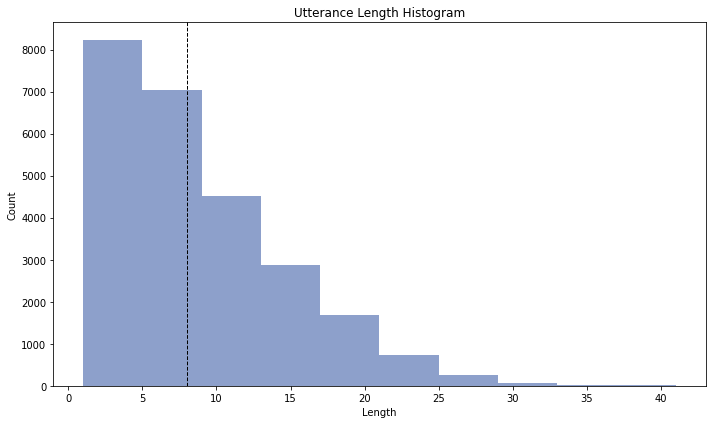

In [ ]:
import scipy.stats as st

seq_lens = [len(seq) for seq in seqs]
plt.figure(figsize=(10,6), tight_layout=True)
plt.hist(seq_lens, color=sns.color_palette('Set2')[2], linewidth=2)
plt.axvline(seq_lens[len(seq_lens)//2], color='k', linestyle='dashed', linewidth=1)
plt.title('Utterance Length Histogram')
plt.xlabel('Length')
plt.ylabel('Count')
plt.savefig('images/Utterance Length Histogram.png')

In [ ]:
slots_by_domain = {i:[] for i in unique_domains}

for i in range(len(domains)):
  slots_by_domain[domains[i]] += [s.split('-')[1] for s in token_slot[i] if 'B-' in s]

for this_domain in unique_domains:
  plt.figure(figsize=(20,6), tight_layout=True)
  plt.hist(slots_by_domain[this_domain], color=sns.color_palette('Set2')[2], linewidth=2)
  plt.title(('Slot Distribution in domain of '+this_domain))
  plt.xlabel('Slot')
  plt.ylabel('Count')
  plt.show()
  plt.savefig('Slot Distribution in domain of '+this_domain+'.png')

# Dataset Preparation

In [ ]:
!pip install pytorch-pretrained-bert pytorch-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install spacy ftfy==4.4.3
!python -m spacy download en
!pip install --upgrade sagemaker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-02-13 01:16:10.681265: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-13 01:16:10.681381: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-13 01:16:10.681399: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use t

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#from keras_preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertModel
from tqdm import tqdm, trange
import pandas as pd
import io

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
lEnc_slot = LabelEncoder()
lEnc_intent = LabelEncoder()
lEnc_domain = LabelEncoder()
slots=np.array(['<PAD>']+sorted(set([x for xs in token_slot for x in xs]))+['[CLS]', '[SEP]'])
domains = np.array(sorted(set(domains)))
intents=np.array(sorted(set(intents)))
lEnc_slot.fit(slots)
lEnc_intent.fit(intents)
lEnc_domain.fit(domains)

integer_mapping_slot = {l: i for i, l in enumerate(lEnc_slot.classes_)}
integer_mapping_intent = {l: i for i, l in enumerate(lEnc_intent.classes_)}
integer_mapping_domain = {l: i for i, l in enumerate(lEnc_domain.classes_)}
print(integer_mapping_slot)
print(integer_mapping_intent)
print(integer_mapping_domain)

train_slot_transformed=[]
dev_slot_transformed=[]
test_slot_transformed=[]

for seq_tr in train_token_slot:
  label=lEnc_slot.transform(seq_tr)
  train_slot_transformed.append(label)

for seq_de in dev_token_slot:
  label=lEnc_slot.transform(seq_de)
  dev_slot_transformed.append(label)

for seq_te in test_token_slot:
  label=lEnc_slot.transform(seq_te)
  test_slot_transformed.append(label)

train_intent_transformed=lEnc_intent.transform(train_intent)
dev_intent_transformed=lEnc_intent.transform(dev_intent)
test_intent_transformed=lEnc_intent.transform(test_intent)

train_domain_transformed=lEnc_domain.transform(train_domain)
dev_domain_transformed=lEnc_domain.transform(dev_domain)
test_domain_transformed=lEnc_domain.transform(test_domain)
pad_slot_id=integer_mapping_slot['<PAD>']

{'<PAD>': 0, 'B-category': 1, 'B-date': 2, 'B-location': 3, 'B-meal': 4, 'B-movie': 5, 'B-num_people': 6, 'B-num_tickets': 7, 'B-price_range': 8, 'B-rating': 9, 'B-restaurant_name': 10, 'B-theatre_name': 11, 'B-time': 12, 'I-date': 13, 'I-location': 14, 'I-movie': 15, 'I-price_range': 16, 'I-rating': 17, 'I-restaurant_name': 18, 'I-theatre_name': 19, 'I-time': 20, 'O': 21, '[CLS]': 22, '[SEP]': 23}
{'AFFIRM': 0, 'CANT_UNDERSTAND': 1, 'CONFIRM': 2, 'GOOD_BYE': 3, 'GREETING': 4, 'INFORM': 5, 'NEGATE': 6, 'NOTIFY_FAILURE': 7, 'NOTIFY_SUCCESS': 8, 'OFFER': 9, 'OTHER': 10, 'REQUEST': 11, 'REQUEST_ALTS': 12, 'SELECT': 13, 'THANK_YOU': 14}
{'MOVIE': 0, 'RESTAURANT': 1}


In [ ]:
train_seq[100]

['how', 'about', 'at', 'amarin']

In [ ]:
# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train = [["[CLS]"] + query + ["[SEP]"] for query in train_seq]
test = [["[CLS]"] + query + ["[SEP]"] for query in test_seq]
train_mid=[]
for seq in train:
  words = [tokenizer.tokenize(w) for w in seq]
  this_sen = []
  for tokenized_parts in words:
    this_sen += tokenized_parts
  train_mid.append(this_sen)
test_mid=[]
for seq in test:
  words = [tokenizer.tokenize(w) for w in seq]
  this_sen = []
  for tokenized_parts in words:
    this_sen += tokenized_parts
  test_mid.append(this_sen)

train_slot_mid = [[integer_mapping_slot['[CLS]']] + list(query) + \
                  [integer_mapping_slot['[SEP]']] for query in train_slot_transformed]
test_slot_mid = [[integer_mapping_slot['[CLS]']] + list(query) + \
                 [integer_mapping_slot['[SEP]']] for query in test_slot_transformed]

id = 321
print(train_mid[id])
print(test_mid[id])
print(train_slot_mid[id])
print(test_slot_mid[id])

100%|██████████| 231508/231508 [00:00<00:00, 347555.05B/s]


['[CLS]', 'at', 'il', 'for', '##nai', '##o', ',', 'please', '.', '[SEP]']
['[CLS]', 'the', 'ivy', 'please', '[SEP]']
[22, 21, 10, 18, 21, 21, 21, 23]
[22, 10, 18, 21, 23]


In [ ]:
max_turn_len = 20
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
# Pad our input tokens
train_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in train_mid],
                          maxlen=max_turn_len, dtype="long", truncating="post", padding="post")
test_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in test_mid],
                          maxlen=max_turn_len, dtype="long", truncating="post", padding="post")

train_slot_ids = pad_sequences(train_slot_mid,
                          maxlen=max_turn_len, dtype="long", truncating="post", padding="post", value=pad_slot_id)
test_slot_ids = pad_sequences(test_slot_mid,
                          maxlen=max_turn_len, dtype="long", truncating="post", padding="post", value=pad_slot_id)

In [ ]:
train_input_ids[4]

array([ 101, 2023, 5958, 1012,  102,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
# Create attention masks
train_attention_masks = []
test_attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for s in train_input_ids:
  seq_mask = [float(i>0) for i in s]
  train_attention_masks.append(seq_mask)
for s in test_input_ids:
  seq_mask = [float(i>0) for i in s]
  test_attention_masks.append(seq_mask)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_input_ids)
test_inputs = torch.tensor(test_input_ids)
train_labels = torch.tensor(train_intent_transformed)
test_labels = torch.tensor(test_intent_transformed)
train_slots = torch.tensor(train_slot_ids)
test_slots = torch.tensor(test_slot_ids)
train_masks = torch.tensor(train_attention_masks)
test_masks = torch.tensor(test_attention_masks)
train_labels_domain = torch.tensor(train_domain_transformed)
test_labels_domain = torch.tensor(test_domain_transformed)

In [ ]:
# Select a batch size for training.
batch_size = 256

# Create an iterator of our data with torch DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels, train_slots, train_labels_domain)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels, test_slots, test_labels_domain)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

train_sampler_ = SequentialSampler(train_data)
train_dataloader_ = DataLoader(train_data, sampler=train_sampler_, batch_size=batch_size)

In [ ]:
def process_mask(mask_in_batch):
  for i,mask in enumerate(mask_in_batch):
    sep_index=int(mask.sum()-1)
    b_input_mask[i][0]=0
    b_input_mask[i][sep_index]=0
  return mask_in_batch

# Evaluation

In [ ]:
!pip install seqeval
from seqeval.metrics import accuracy_score
from seqeval.metrics import f1_score
from seqeval.metrics import precision_score
from seqeval.metrics import recall_score
from seqeval.metrics import classification_report as seqeval_classification_report
from sklearn.metrics import f1_score as f_score
from sklearn.metrics import recall_score as re_score
from sklearn.metrics import precision_score as pre_score
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
ind2slot={v:k for k,v in list(integer_mapping_slot.items())}
ind2intent={v:k for k,v in list(integer_mapping_intent.items())}
ind2domain={v:k for k,v in list(integer_mapping_domain.items())}

# Intent

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
from torch.nn import CrossEntropyLoss, MSELoss

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
class BertForIntentClassification(nn.Module):
  def __init__(self, num_labels):
    super(BertForIntentClassification, self).__init__()
    self.num_labels=num_labels
    self.bert=BertModel.from_pretrained("bert-base-uncased")
    self.dropout = nn.Dropout(0.1)
    self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    self._init_weights()

  def _init_weights(self):
    """ Initialize the weights """
    print("Initializing linear weight")
    self.classifier.weight.data.normal_(mean=0.0, std=self.bert.config.initializer_range)

  def forward(self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None):

    outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

    pooled_output = outputs[1]
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
    outputs = (logits,) + (outputs[0][-1],)

    if labels is not None:
        if self.num_labels == 1:
            #  We are doing regression
            loss_fct = MSELoss()
            loss = loss_fct(logits.view(-1), labels.view(-1))
        else:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        outputs = (loss,) + outputs

    return outputs  # (loss), logits, (hidden_states), (attentions)

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model_intent=BertForIntentClassification(len(integer_mapping_slot))
model_intent.cuda()

Initializing linear weight


BertForIntentClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
     

In [ ]:
!pip install torchviz
from torchviz import make_dot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# BERT fine-tuning parameters
param_optimizer = list(model_intent.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs
epochs = 20

In [ ]:
# BERT training loop
for _ in trange(epochs, desc="Epoch"):

  ## TRAINING

  model_intent.train()
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, _, b_domains = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass

    (loss, _, _, ) = model_intent(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    make_dot(loss, params=dict(model_intent.named_parameters()), show_attrs=True, show_saved=True)
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  next_m.mul_(beta1).add_(1 - beta1, grad)
Epoch:   0%|          | 0/1 [00:11<?, ?it/s]


RuntimeError: ignored

In [ ]:
# Put model in evaluati mode
model_intent.eval()

train_intent_embedding=[]
for batch in train_dataloader_:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, _, b_domains = batch

  # Telling the model not to compute or store gradients, saving memory and speeding up validation
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    (_, _, hidden_layer, ) = model_intent(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    dim=hidden_layer.size(-1)
    b_input_mask=process_mask(b_input_mask)
    b_input_mask=b_input_mask.unsqueeze(-1).repeat(1,1,dim)
    embed=hidden_layer*b_input_mask
    train_intent_embedding.extend(np.array(embed[:,1:-1,:].cpu()))

# Tracking variables
test_accuracy = 0
test_intent_embedding=[]
y_pred = []
y_true = []

for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, _, b_domains = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up validation
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    (_, logits, hidden_layer, ) = model_intent(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    dim=hidden_layer.size(-1)
    b_input_mask=process_mask(b_input_mask)
    b_input_mask=b_input_mask.unsqueeze(-1).repeat(1,1,dim)
    embed=hidden_layer*b_input_mask
    test_intent_embedding.extend(np.array(embed[:,1:-1,:].cpu()))   #Remove [CLS] and [SEP]

    # Move logits and labels to CPU
    y_pred.append(logits.detach().cpu().numpy())
    y_true.append(b_labels.to('cpu').numpy())

y_pred = np.argmax(np.concatenate(y_pred),1)
y_true = np.concatenate(y_true)

In [ ]:
y_true[0]

array([21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 23, 22, 22, 22,
       22, 22, 22])

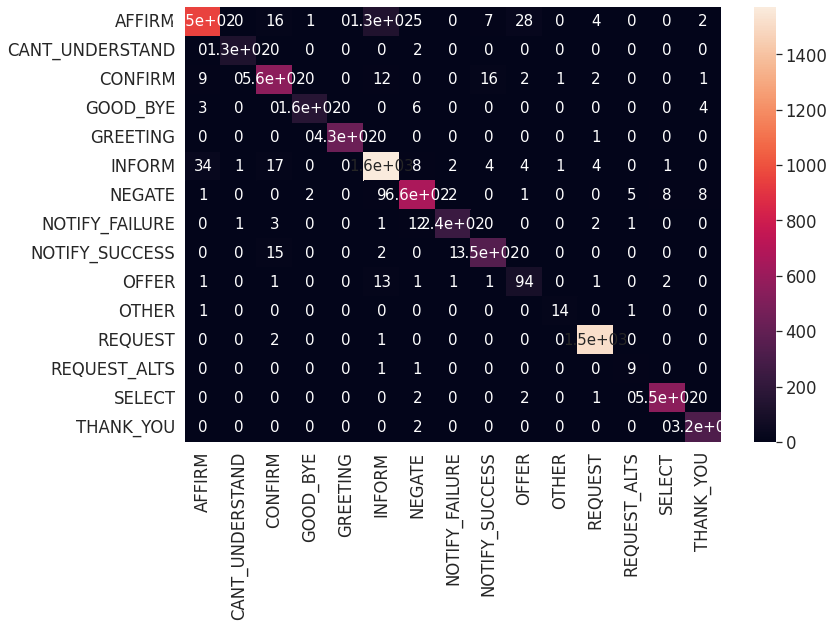

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


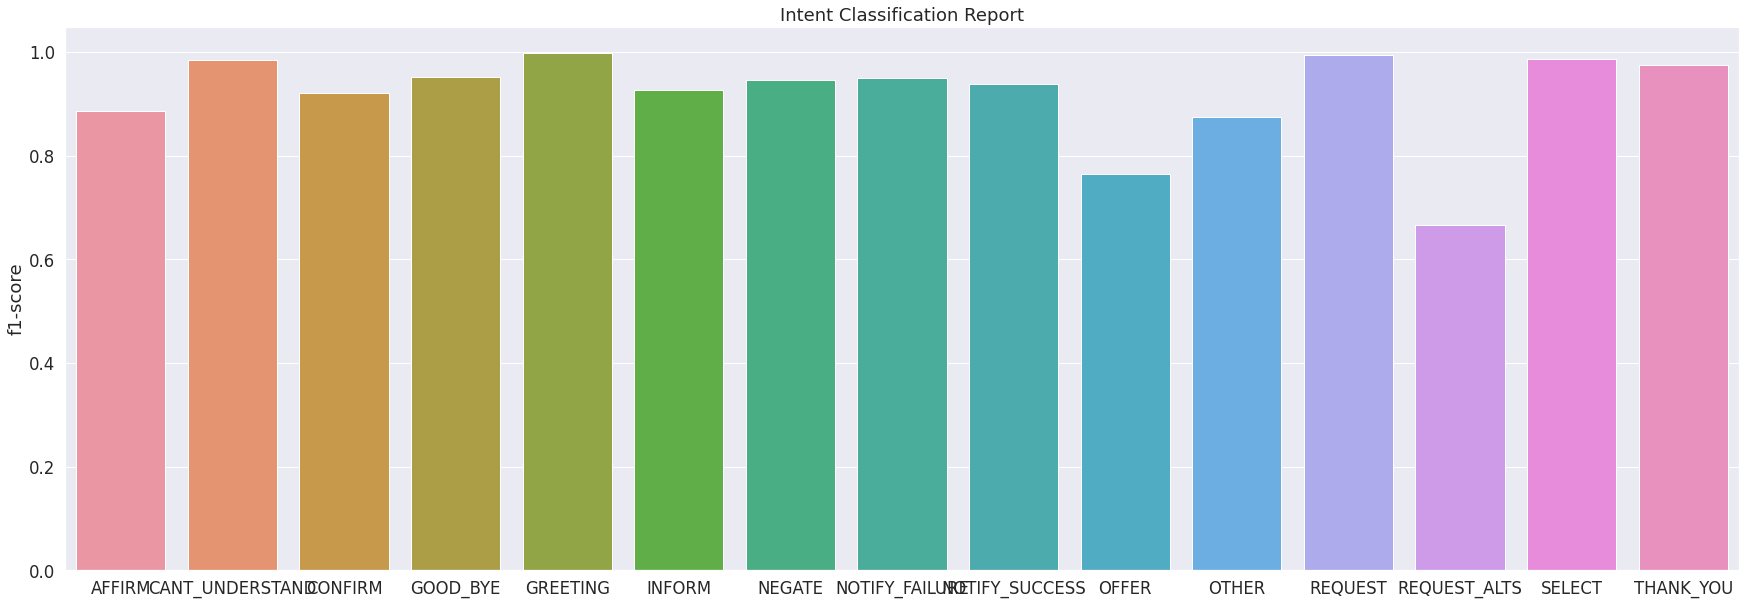

In [ ]:
import seaborn as sn
from sklearn.metrics import classification_report

# Confusion Matrix
from sklearn.metrics import confusion_matrix
df_cm = pd.DataFrame(confusion_matrix(y_true, y_pred), index=unique_intents)
df_cm.rename(columns = {i: unique_intents[i] for i in df_cm.head()}, inplace = True)
plt.figure(figsize=(12,8))
sn.set(font_scale=1.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}) # font size
plt.show()

intent_classification_report = classification_report(y_true, y_pred, target_names=unique_intents, output_dict=True)
intent_df = pd.DataFrame(intent_classification_report).transpose()
plt.rcParams["figure.figsize"] = (30, 10)
sns.barplot(unique_intents, intent_df['f1-score'][:-3]).set(title='Intent Classification Report')
intent_df.to_csv("evaluations/BERT_intent.csv")
plt.savefig("images/Intent classification report via Bert.png")

In [ ]:
train_intent_embedding=np.array(train_intent_embedding)
test_intent_embedding=np.array(test_intent_embedding)
print(train_intent_embedding.shape)
print(test_intent_embedding.shape)

(13974, 18, 768)
(7998, 18, 768)


In [ ]:
import h5py

with h5py.File("train_bert_intent_embedding.h5", 'w') as f:
  f["data"] = np.array(train_intent_embedding)

with h5py.File("test_bert_intent_embedding.h5", 'w') as f:
  f["data"] = np.array(test_intent_embedding)

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a text file.
uploaded = drive.CreateFile({'title': 'train_bert_intent_embedding.h5'})
uploaded.SetContentFile('train_bert_intent_embedding.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))
uploaded = drive.CreateFile({'title': 'test_bert_intent_embedding.h5'})
uploaded.SetContentFile('test_bert_intent_embedding.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1p72fDR3A0TRSsUd_emzveZIQtDTduJAB
Uploaded file with ID 1TGOV10AhvGSd0rOTOfcpHUGR4Msxj9Jc


# Slot

In [ ]:
class BertForSlotFilling(nn.Module):
  def __init__(self, num_labels, ignore_index=None):
    super(BertForSlotFilling, self).__init__()
    self.num_labels=num_labels
    self.ignore_index=ignore_index
    self.bert=BertModel.from_pretrained("bert-base-uncased")
    self.dropout = nn.Dropout(0.1)
    self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    self._init_weights()


  def _init_weights(self):
    """ Initialize the weights """
    print("Initializing linear weight")
    self.classifier.weight.data.normal_(mean=0.0, std=self.bert.config.initializer_range)

  def forward(self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None):

    outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

    sequence_output = outputs[0][-1]

    sequence_output = self.dropout(sequence_output)
    logits = self.classifier(sequence_output)


    outputs = (logits,) + (outputs[0][-1],)



    if labels is not None:
       loss_fct = nn.CrossEntropyLoss(ignore_index=self.ignore_index)
       if attention_mask is not None:
          active_loss = attention_mask.view(-1) == 1
          active_logits = logits.view(-1, self.num_labels)[active_loss]
          active_labels = labels.view(-1)[active_loss]
          loss = loss_fct(active_logits, active_labels)
       else:
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
       outputs = (loss,) + outputs

    return outputs  # (loss), logits, (hidden_states), (attentions)

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model_slot=BertForSlotFilling(len(integer_mapping_slot), pad_slot_id)
model_slot.cuda()

Initializing linear weight


BertForSlotFilling(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )


In [ ]:
# BERT fine-tuning parameters
param_optimizer = list(model_slot.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs
epochs = 20

In [ ]:
# BERT training loop
for _ in trange(epochs, desc="Epoch"):

  ## TRAINING

  # Set our model to training mode
  model_slot.train()
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, _, b_slot_labels, _ = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    (loss, _, _, ) = model_slot(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_slot_labels)

    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  next_m.mul_(beta1).add_(1 - beta1, grad)
Epoch:   5%|▌         | 1/20 [00:22<07:16, 22.99s/it]

Train loss: 0.6755317758430134


Epoch:  10%|█         | 2/20 [00:44<06:41, 22.29s/it]

Train loss: 0.17287929247726094


Epoch:  15%|█▌        | 3/20 [01:06<06:14, 22.05s/it]

Train loss: 0.08960620266470042


Epoch:  20%|██        | 4/20 [01:28<05:51, 21.99s/it]

Train loss: 0.06138572858815843


Epoch:  25%|██▌       | 5/20 [01:50<05:29, 21.93s/it]

Train loss: 0.04602519520981745


Epoch:  30%|███       | 6/20 [02:12<05:06, 21.90s/it]

Train loss: 0.038260315731167796


Epoch:  35%|███▌      | 7/20 [02:33<04:44, 21.86s/it]

Train loss: 0.03257833048701286


Epoch:  40%|████      | 8/20 [02:55<04:22, 21.83s/it]

Train loss: 0.028966884348880163


Epoch:  45%|████▌     | 9/20 [03:17<04:00, 21.88s/it]

Train loss: 0.025848558070984753


Epoch:  50%|█████     | 10/20 [03:39<03:39, 21.91s/it]

Train loss: 0.02262717854570259


Epoch:  55%|█████▌    | 11/20 [04:01<03:17, 21.93s/it]

Train loss: 0.02047985741360621


Epoch:  60%|██████    | 12/20 [04:23<02:55, 21.96s/it]

Train loss: 0.01932881186631593


Epoch:  65%|██████▌   | 13/20 [04:45<02:34, 22.00s/it]

Train loss: 0.01786196143789725


Epoch:  70%|███████   | 14/20 [05:07<02:12, 22.06s/it]

Train loss: 0.01688614333556457


Epoch:  75%|███████▌  | 15/20 [05:29<01:50, 22.04s/it]

Train loss: 0.015447202477265488


Epoch:  80%|████████  | 16/20 [05:51<01:28, 22.03s/it]

Train loss: 0.014498098846524953


Epoch:  85%|████████▌ | 17/20 [06:13<01:06, 22.02s/it]

Train loss: 0.012841552081094547


Epoch:  90%|█████████ | 18/20 [06:35<00:44, 22.02s/it]

Train loss: 0.012137931373647668


Epoch:  95%|█████████▌| 19/20 [06:57<00:22, 22.01s/it]

Train loss: 0.01208812975409356


Epoch: 100%|██████████| 20/20 [07:19<00:00, 21.99s/it]

Train loss: 0.011638728029687297


In [ ]:
# Put model in evaluation mode
model_slot.eval()

train_slot_embedding=[]
for batch in train_dataloader_:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, _, b_slot_labels, _ = batch

  # Telling the model not to compute or store gradients, saving memory and speeding up validation
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    (_, _, hidden_layer, ) = model_slot(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_slot_labels)
    dim=hidden_layer.size(-1)
    b_input_mask=process_mask(b_input_mask)
    b_input_mask=b_input_mask.unsqueeze(-1).repeat(1,1,dim)
    embed=hidden_layer*b_input_mask
    train_slot_embedding.extend(np.array(embed[:,1:-1,:].cpu()))

y_pred = []
y_true = []
test_slot_embedding=[]
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, _, b_slot_labels, _ = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up validation
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    (_, logits, hidden_layer, ) = model_slot(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_slot_labels)
    dim=hidden_layer.size(-1)
    b_input_mask=process_mask(b_input_mask)
    embed=hidden_layer*b_input_mask.unsqueeze(-1).repeat(1,1,dim)
    test_slot_embedding.extend(np.array(embed[:,1:-1,:].cpu()))
    logits = torch.argmax(logits,2) * b_input_mask
    b_slot_labels = b_slot_labels * b_input_mask
    # Move logits and labels to CPU
    y_pred.append(logits.detach().cpu().numpy())
    y_true.append(b_slot_labels.to('cpu').numpy())

y_pred = np.concatenate(y_pred,0).flatten()
y_true = np.concatenate(y_true,0).flatten()

In [ ]:
# import seaborn as sn
# from sklearn.metrics import classification_report

# # Confusion Matrix
# from sklearn.metrics import confusion_matrix

# slot_labels = list(integer_mapping_slot.keys())
# slot_report = pd.DataFrame(classification_report(y_true,y_pred,output_dict=True, target_names=unique_slots)).iloc[:-1, :].T
# slot_report.to_csv("evaluations/BERT_slot.csv")
# plt.savefig("images/Slot classification report via Bert.png")

In [ ]:
train_slot_embedding=np.array(train_slot_embedding)
test_slot_embedding=np.array(test_slot_embedding)
print(train_slot_embedding.shape)
print(test_slot_embedding.shape)

(13974, 18, 768)
(7998, 18, 768)


In [ ]:
import h5py

with h5py.File("embeddings/train_bert_slot_embedding.h5", 'w') as f:
  f["data"] = np.array(train_slot_embedding)

with h5py.File("embeddings/test_bert_slot_embedding.h5", 'w') as f:
  f["data"] = np.array(test_slot_embedding)

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a text file.
uploaded = drive.CreateFile({'title': 'embeddings/train_bert_slot_embedding.h5'})
uploaded.SetContentFile('embeddings/train_bert_slot_embedding.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))
uploaded = drive.CreateFile({'title': 'embeddings/test_bert_slot_embedding.h5'})
uploaded.SetContentFile('embeddings/test_bert_slot_embedding.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1qsVtp0qYiyTPhmrHYkIj3V2o6OwR_cqj
Uploaded file with ID 1bjJfAIhP9Wjr_i_J5yUPxGDUiRS8sp9L


# Domain

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model_domain=BertForIntentClassification(len(integer_mapping_domain))
model_domain.cuda()

In [ ]:
# BERT fine-tuning parameters
param_optimizer = list(model_domain.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs
epochs = 20

In [ ]:
# BERT training loop
for _ in trange(epochs, desc="Epoch"):

  ## TRAINING

  # Set our model to training mode
  model_domain.train()
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, _, _, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    (loss, _, _, ) = model_domain(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))

In [ ]:
# Put model in evaluation mode
model_domain.eval()

train_domain_embedding=[]
for batch in train_dataloader_:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, _, _, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and speeding up validation
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    (_, _, hidden_layer, ) = model_domain(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    dim=hidden_layer.size(-1)
    b_input_mask=process_mask(b_input_mask)
    b_input_mask=b_input_mask.unsqueeze(-1).repeat(1,1,dim)
    embed=hidden_layer*b_input_mask
    train_domain_embedding.extend(np.array(embed[:,1:-1,:].cpu()))

y_pred = []
y_true = []
test_domain_embedding=[]
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, _, _, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up validation
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    (_, logits, hidden_layer, ) = model_domain(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    dim=hidden_layer.size(-1)
    b_input_mask=process_mask(b_input_mask)
    b_input_mask=b_input_mask.unsqueeze(-1).repeat(1,1,dim)
    embed=hidden_layer*b_input_mask
    test_domain_embedding.extend(np.array(embed[:,1:-1,:].cpu()))

    # Move logits and labels to CPU
    y_pred.append(logits.detach().cpu().numpy())
    y_true.append(b_labels.to('cpu').numpy())

y_pred = np.argmax(np.concatenate(y_pred),1)
y_true = np.concatenate(y_true)

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(y_true, y_pred), index=unique_domains)
df_cm.rename(columns = {i: unique_domains[i] for i in df_cm.head()}, inplace = True)
plt.figure(figsize=(12,8))
sn.set(font_scale=1.5) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}) # font size
plt.show()

domain_classification_report = classification_report(y_true, y_pred, target_names=unique_domains, output_dict=True)
domain_df = pd.DataFrame(domain_classification_report).transpose()
plt.rcParams["figure.figsize"] = (20, 20)
sns.barplot(unique_domains, domain_df['f1-score'][:-3]).set(title='Domain Classification Report')
domain_df.to_csv("evaluations/BERT_domain.csv")
plt.savefig("images/Domain classification report via Bert.png")

In [ ]:
train_domain_embedding=np.array(train_domain_embedding)
test_domain_embedding=np.array(test_domain_embedding)
print(train_domain_embedding.shape)
print(test_domain_embedding.shape)

In [ ]:
import h5py

with h5py.File("embeddings/train_bert_domain_embedding.h5", 'w') as f:
  f["data"] = np.array(train_domain_embedding)

with h5py.File("embeddings/test_bert_domain_embedding.h5", 'w') as f:
  f["data"] = np.array(test_domain_embedding)


In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a text file.
uploaded = drive.CreateFile({'title': 'embeddings/train_bert_domain_embedding.h5'})
uploaded.SetContentFile('embeddings/train_bert_domain_embedding.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))
uploaded = drive.CreateFile({'title': 'embeddings/test_bert_domain_embedding.h5'})
uploaded.SetContentFile('embeddings/test_bert_domain_embedding.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))